# Yelp Restaurant Review Scorer

### Package Import and Notebook Config

In [1]:
from pathlib import Path
import pandas as pd
import json
import joblib
import requests
import matplotlib.pyplot as plt
import re
import unicodedata
import inflect
infl = inflect.engine()

In [2]:
pd.set_option("display.max_columns",None)

SAMPLE_DATA = Path("dataset").resolve()
COMPLETE_DATA = Path("dataset_complete").resolve()

### Raw Data Import and Dataset Build

##### Load a Sample of the Yelp Data
- At time of development, the complete Yelp review dataset is > 5 GB; a more manageably-sized sample is needed
- A sample of the Yelp dataset has been prepared for you in `dataset/`
- Load the prepared sample in the next cell

In [ ]:
reviews_df_complete = joblib.load(SAMPLE_DATA / "reviews_sample.pkl")

##### Preparing Your Own Sample (Optional)
To prepare your own sample of the Yelp dataset, complete these steps:
* Download the complete [Yelp Open Dataset](https://business.yelp.com/data/resources/open-dataset/) here:<br><br>
<img src = "misc/yelp_download.png" format="png" width = "700"></img><br><br>
* Extract the JSON files and store in the empty folder `dataset_complete`
* Ensure that these filenames are used:
    - Reviews data: `yelp_academic_dataset_review.json`
    - Businesses data: `yelp_academic_dataset_business.json`
* Uncomment and execute the next code cell to build and store a custom sample

In [ ]:
# n_rows = 300000

# # load "n_rows" reviews
# reviews = []
# with open(COMPLETE_DATA / "yelp_academic_dataset_review.json", "r") as f1:
#     for i, line in enumerate(f1):
#         if i >= n_rows:
#             break
#         reviews.append(json.loads(line))

# # load "n_rows" businesses -- these are distinct from reviews in the data
# businesses = []
# with open(COMPLETE_DATA / "yelp_academic_dataset_business.json","r") as f2:
#     for i, line in enumerate(f2):
#         if i >= n_rows:
#             break
#         businesses.append(json.loads(line))

# # join to build a sample review dataset
# reviews_sample = pd.merge(
#   pd.DataFrame(reviews),
#   pd.DataFrame(businesses),
#   how = "inner",
#   on = "business_id",
#   suffixes = ["_review","_restaurant"]
#   ).dropna()

# # store the reviews sample locally
# joblib.dump(reviews_sample, SAMPLE_DATA / "reviews_sample.pkl")

# reviews_df_complete = reviews_sample.copy()


##### Create a Subsample for Applying the Model
- This section isolates one or more restaurants to evaluate using the model
- Current code is set up to demonstrate the model for a batch of three restaurants, but this can be modified

In [5]:
n_sample = 3 # set the number of restaurants here

In [6]:
# compute average stars for each restaurant
# evaluating restaurants with low average stars may produce more interesting results
reviews_df_complete = pd.merge(
    reviews_df_complete,
    reviews_df_complete.groupby("business_id")["stars_review"].mean().rename("avg_stars"),
    how = "inner",
    on = "business_id"
)

In [7]:
# filter the dataset for restaurants only 
cond1 = reviews_df_complete["categories"].str.lower().str.contains("restaurants")

# explicitly remove hotels to ensure the dataset contains *standalone* restaurants only
cond2 = reviews_df_complete["categories"].str.lower().str.contains("hotels") 

# optional: filter for restaurants with mixed reviews for more interesting results
cond3 = reviews_df_complete["avg_stars"] < 4

reviews_df_complete = reviews_df_complete[
    (cond1) 
    & (~cond2)
#    & (cond3)
]

In [8]:
# sample the data for n restaurants with >= 100 and <= 200 reviews (this is the optimal demonstration quantity)
review_counts = reviews_df_complete.groupby("business_id")["review_id"].count().rename("total_reviews")
sample_id = review_counts[review_counts.between(100,200)].sample(n_sample).index.tolist()

reviews_df = reviews_df_complete.copy()[reviews_df_complete["business_id"].isin(sample_id)]
reviews_df = reviews_df[["business_id","name","text"]].sort_values(by = "name").reset_index(drop = True)

# reintroduce review counts into the sample dataframe -- this will come in handy later
reviews_df = pd.merge(reviews_df,review_counts,how = "inner",on = "business_id").drop('business_id',axis = 1)

### Function Builds
Custom functionality includes:
- Cleanup of nonstandard ascii characters (ampersands, escape characters) to make LLM interpretation easier
- Arraying of possible classes (class = evaluation of review content, such as "positive" or "disappointed") in natural language
- Prompt build
- Executing model evaluation of review content according to prompt instructions
- Parsing model output into JSON format
- Generation of model output that must be reprocessed

In [9]:
def CleanReviewText(text):
    """
    Removes & and nonstandard ascii characters to make the LLM's interpretation job easier
    """

    if not isinstance(text, str):
        return ""

    # Normalize Unicode (e.g., é → e)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")

    # Replace ampersands with "and" when used as a connector
    text = re.sub(r'\s*&\s*', ' and ', text)

    # Replace all forms of whitespace (tabs, newlines, multiple spaces) with a single space
    text = re.sub(r'\s+', ' ', text)

    # Trim leading/trailing whitespace
    return text.strip()


reviews_df["text"] = reviews_df["text"].apply(CleanReviewText)

In [10]:
def FormatClassList(values, max_items=None):
    """
    Transform the list of classes into different phrasings in natural English.
    Useful for dynamically passing possible classes to the prompt.
    """
    if max_items:
        values = values[:max_items]
    
    if not values:
        return ""
    elif len(values) == 1:
        return values[0]
    elif len(values) == 2:
        return f"{values[0]} and {values[1]}"
    else:
        return ", ".join(values[:-1]) + f", and {values[-1]}"

In [11]:
def BuildPrompt(business_name,classes,reprocess = False):
    """
    Build the prompt that will be passed to the LLM.
    Using a function allows the prompt to be printed and previewed.
    """

    prompt = f"""
You are a restaurant review classifier that is reviewing {business_name}.
Given a review of {business_name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {{"food": "[class]", "service": "[class]", "ambiance": "[class]"}}.
For [class], return one of {infl.number_to_words(len(valid_classes))} possible values: {FormatClassList(classes)}.
{FormatClassList(classes[:-1])} are classifications of the reviewer's feelings toward their experience.
Return "{FormatClassList(classes[-1:])}" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {{"food": "{classes[1]}", "service": "{classes[2]}", "ambiance": "{classes[3]}"}}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {{"food": "{classes[0]}", "service": "{classes[0]}", "ambiance": "{classes[0]}"}}.
No other output is desired.
    """
    if reprocess == True:
        prompt += f"""
Please focus on selecting a class from these values: {FormatClassList(classes)}. 
Other class choices, even if more descriptive, are not helpful in this instance.
If the reviewer has mixed opinions (a combination of positive, disappointed, and/or angry) about an aspect of their experience, bias toward the negative; 
that is, classify according to the more negative statements and choose "{valid_classes[0]}" only if the review is solely comprised of positive statements.
        """

    return prompt

In [12]:
def ClassifyReview(review_text, business_name, classes, model='mistral',reprocess = False):
    """
    Build the prompt and pass to the LLM for evaluation.
    """

    url = "http://localhost:11434/api/chat"
    headers = {"Content-Type": "application/json"}
      
    data = {
        "model": model,
        "messages": [
            {
                "role": "system",
                "content": BuildPrompt(business_name,classes,reprocess) 
            },
            {
                "role": "user",
                "content": review_text
            }
        ],
        "stream": False
    }

    response = requests.post(url, json=data, headers=headers)
    return response.json()["message"]["content"]


In [13]:
def ParseReviewAnalyticsOutput(text):
    """
    Parses potentially messy JSON-like LLM output by:
    - Truncating after the first closing brace
    - Quoting unquoted keys
    - Quoting unquoted string values
    - Removing parenthetical commentary from values
    - Falling back to regex if JSON parsing fails
    Returns a dictionary with aspect classifications.
    """
    # Truncate at first closing brace to avoid trailing commentary
    text = text.strip()
    closing_brace_index = text.find("}")
    if closing_brace_index != -1:
        text = text[:closing_brace_index + 1]

    # Remove parenthetical notes from values (e.g., "none (but blah)" -> "none")
    text = re.sub(r'"\s*([^"]*?)\s*\([^"]*\)"', r'"\1"', text)

    # Fix unquoted keys
    text = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', text)

    # Fix unquoted string values (assume words are categorical, not numbers or booleans)
    text = re.sub(r':\s*([a-zA-Z_]+)(\s*[,}])', r': "\1"\2', text)

    # Try JSON parsing
    try:
        parsed = json.loads(text)
        return {
            "food": parsed.get("food", "none").split()[0].lower(),
            "service": parsed.get("service", "none").split()[0].lower(),
            "ambiance": parsed.get("ambiance", "none").split()[0].lower()
        }
    except Exception:
        pass  # fallback to regex next

    # Fallback regex-based parsing
    result = {"food": "none", "service": "none", "ambiance": "none"}
    for aspect in ["food", "service", "ambiance"]:
        match = re.search(rf'{aspect}\s*[:=]\s*["\']?(\w+)', text, re.IGNORECASE)
        if match:
            result[aspect] = match.group(1).lower()

    return result


In [14]:
def GenerateReprocessData(df,classes):
    """
    Checks model output for classifications that were not asked for in the prompt
    If invalid output is found, remove from the main results dataset and set aside for reprocessing
    """
    invalid_food = ~df["food"].isin(classes)
    invalid_service = ~df["service"].isin(classes)
    invalid_ambiance = ~df["ambiance"].isin(classes)

    to_reprocess = df[invalid_food | invalid_service | invalid_ambiance]
    df = df.drop(labels = to_reprocess.index)
    to_reprocess = to_reprocess.reset_index(drop=True)
    return df,to_reprocess

### Review Evaluation Config
- Set the possible classes (class = evaluation of review content, such as "positive" or "disappointed") here
- View a printout of the finished prompt

In [15]:
valid_classes = ["positive","disappointed","angry","none"]

print(BuildPrompt(business_name="{restaurant name}",classes=valid_classes,reprocess=True))


You are a restaurant review classifier that is reviewing {restaurant name}.
Given a review of {restaurant name}, classify the reviewer's attitude toward three key aspects: food and drinks (including prices), service, and ambiance.
Return a JSON-style matrix in this form: {"food": "[class]", "service": "[class]", "ambiance": "[class]"}.
For [class], return one of four possible values: positive, disappointed, angry, and none.
positive, disappointed, and angry are classifications of the reviewer's feelings toward their experience.
Return "none" if the reviewer does not address a certain aspect of the experience.
Here is an example review: "The appetizers at this place were phenomenal, but the margaritas were overpriced and watery. Service was HORRENDOUS."
In this example, return: {"food": "disappointed", "service": "angry", "ambiance": "none"}.
Here is another example: "Our server was outstanding and the entrees were perfectly cooked. We loved the decor, too!"
In this example, return: {"

### Process Analytics
- Pass all review content through the LLM to assign a class to each review
- When the LLM assigns a class that was not asked for, isolate that review and reprocess it (two reprocessing cycles only)

##### Initial Processing Cycle (Longest)

In [16]:
%%time

# Process all reviews in the dataset. This is the most time-consuming execution step.
result_list = []
for review in reviews_df.itertuples():
    result = ClassifyReview(review.text,business_name=review.name,classes=valid_classes,reprocess = False)
    result_list.append(result)

CPU times: user 1.2 s, sys: 279 ms, total: 1.48 s
Wall time: 10min 19s


In [17]:
result_df = pd.concat([reviews_df,(pd.DataFrame(pd.Series(result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

##### First Reprocessing Cycle

In [18]:
# "neutral" is a common hallucination that the LLM has; this is best replaced with "none" to save reprocessing compute
result_df = result_df.replace(to_replace="neutral",value=valid_classes[-1])

In [19]:
# isolate reviews with invalid classes for reprocessing
result_df,to_reprocess = GenerateReprocessData(result_df,valid_classes)

# store the quantity of model output values where reprocessing is needed; will show up later in reprocessing statistics
repr_stage1_invalid = to_reprocess[["food","service","ambiance"]].size - to_reprocess[["food","service","ambiance"]].isin(valid_classes).sum().sum()

In [20]:
%%time

# Execute reprocessing
repr_result_list = []
for review_repr in to_reprocess.itertuples():
    repr_result = ClassifyReview(review_repr.text,business_name=review_repr.name,classes=valid_classes,reprocess = True)
    repr_result_list.append(repr_result)

CPU times: user 7.19 ms, sys: 2.16 ms, total: 9.35 ms
Wall time: 6.46 s


##### Second Reprocessing Cycle

In [21]:
# recheck the reprocessed data for invalid classes
to_reprocess_again = pd.concat([to_reprocess[["name","text","total_reviews"]],(pd.DataFrame(pd.Series(repr_result_list).apply(ParseReviewAnalyticsOutput).tolist()))],axis = 1)

# as before, store the quantity of model output values where reprocessing is needed for reprocessing statistics
repr_stage2_invalid = to_reprocess_again[["food","service","ambiance"]].size - to_reprocess_again[["food","service","ambiance"]].isin(valid_classes).sum().sum()

Instead of using the model for the second reprocessing, simply replace invalid classes with "none" or whatever neutral class has been defined:

In [22]:
reprocessed = to_reprocess_again.copy()
if reprocessed.shape[0] > 0:
    reprocessed.loc[~reprocessed["food"].isin(valid_classes),["food"]] = valid_classes[-1]
    reprocessed.loc[~reprocessed["service"].isin(valid_classes),["service"]] = valid_classes[-1]
    reprocessed.loc[~reprocessed["ambiance"].isin(valid_classes),["ambiance"]] = valid_classes[-1]


In [23]:
result_df = pd.concat([result_df,reprocessed],axis = 0).reset_index(drop = True)

### Load Result DF Here

In [24]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

joblib.dump(result_df,"scratch_work_files/results_sample3.pkl")
joblib.dump(to_reprocess,"scratch_work_files/pre_reprocess_dataframe3.pkl")
joblib.dump(reprocessed,"scratch_work_files/post_reprocess_dataframe3.pkl")

# result_df = joblib.load("scratch_work_files/results_sample1.pkl")
# to_reprocess = joblib.load("scratch_work_files/pre_reprocess_dataframe1.pkl")
# to_reprocess_again = joblib.load("scratch_work_files/post_reprocess_dataframe1.pkl")

['scratch_work_files/post_reprocess_dataframe3.pkl']

### Plot Analysis Results
- For each restaurant in the sample, show proportions of each class for each aspect (for example: food = 75% positive, 10% disappointed, 5% angry, 10% none)

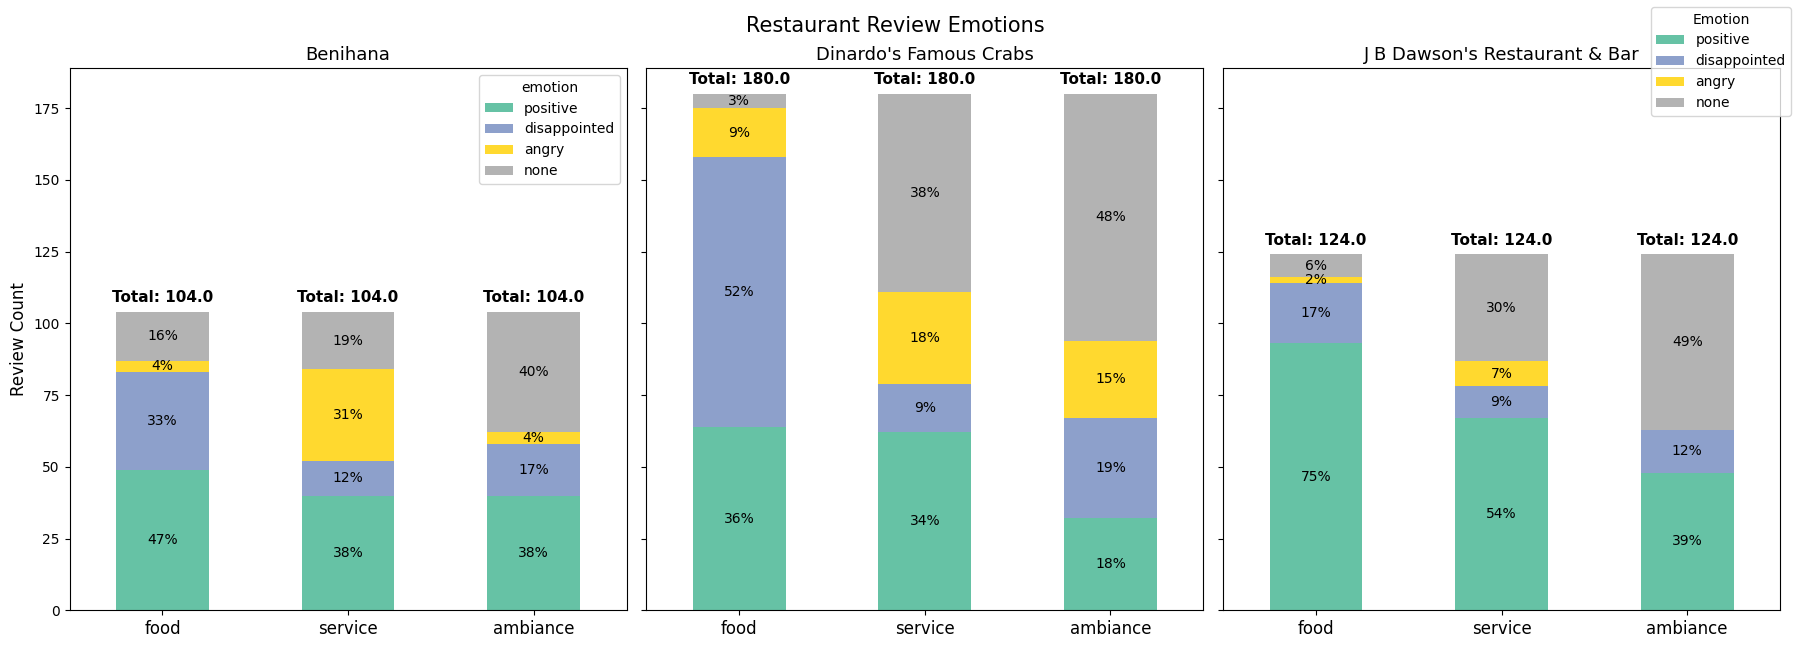

In [25]:
# Melt into long format
melted = result_df.melt(
    id_vars="name",
    value_vars=["food", "service", "ambiance"],
    var_name="aspect",
    value_name="emotion"
)

# Count occurrences
counts = (
    melted.groupby(["name", "aspect", "emotion"])
    .size()
    .reset_index(name="count")
)

# Pivot for stacked bars
pivoted = counts.pivot_table(
    index=["name", "aspect"],
    columns="emotion",
    values="count",
    fill_value=0
)

# Ensure consistent emotion order
emotion_order = ["positive", "disappointed", "angry", "none"]
pivoted = pivoted.reindex(columns=emotion_order, fill_value=0)

# Add row totals for percentage & total labels
pivoted["total"] = pivoted.sum(axis=1)

# Create subplots
restaurants = pivoted.index.get_level_values(0).unique()
n_restaurants = len(restaurants)

fig, axes = plt.subplots(1, n_restaurants, figsize=(6 * n_restaurants, 6.5), sharey=True)

if n_restaurants == 1:
    axes = [axes]

for ax, restaurant in zip(axes, restaurants):
    group = pivoted.loc[restaurant]
    group_no_total = group.drop(columns="total")
    group_no_total.index = pd.Categorical(group_no_total.index,categories=["food","service","ambiance"],ordered=True)
    group_no_total = group_no_total.sort_index()

    # Plot stacked bars
    group_no_total.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="Set2",
        legend=(ax == axes[0])
    )
    ax.set_title(restaurant,fontsize = 13)
    ax.set_ylabel("Review Count",fontsize = 12)
    # ax.set_xlabel("Aspect",fontsize = 12)
    ax.tick_params(axis="x", rotation=0,labelsize = 12)


    # Create annotations
    for container in ax.containers:
        for rect in container:
            height = rect.get_height()
            if height > 0:
                total_height = group["total"].values[0]
                percentage = 100 * height / total_height
                ax.annotate(f"{percentage:.0f}%",
                            xy=(rect.get_x() + rect.get_width() / 2,
                                rect.get_y() + height / 2),
                            ha="center", va="center", fontsize=10, color="black")

    # Add total count labels above bars
    for idx, (aspect, row) in enumerate(group.iterrows()):
        total = row["total"]
        ax.annotate(f"Total: {total}",
                    xy=(idx, total),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=11, fontweight="bold")

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Emotion", loc="upper right")


plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle("Restaurant Review Emotions",fontsize = 15)
plt.show()

In [26]:
# restaurant = "Sher-e-Punjab"
# y_lim_top = group["total"].values[0]*1.3

# fig,ax = plt.subplots(figsize = (8,6))   
# group = pivoted.loc[restaurant]
# group_no_total = group.drop(columns="total")
# group_no_total.index = pd.Categorical(group_no_total.index,categories=["food","service","ambiance"],ordered=True)
# group_no_total = group_no_total.sort_index()

# # Plot stacked bars
# group_no_total.plot(
#     kind="bar",
#     stacked=True,
#     ax=ax,
#     colormap="Set2",
#     legend=(ax == axes[0])
# )
# ax.set_title(restaurant,fontsize = 14)
# ax.set_ylabel("Review Count",fontsize = 10)
# ax.set_ylim(0,y_lim_top)
# # ax.set_xlabel("Aspect",fontsize = 12)
# ax.tick_params(axis="x", rotation=0,labelsize = 10)


# # Create annotations
# for container in ax.containers:
#     for rect in container:
#         height = rect.get_height()
#         if height > 0:
#             total_height = group["total"].values[0]
#             percentage = 100 * height / total_height
#             ax.annotate(f"{percentage:.0f}%",
#                         xy=(rect.get_x() + rect.get_width() / 2,
#                             rect.get_y() + height / 2),
#                         ha="center", va="center", fontsize=10, color="black")

# # Add total count labels above bars
# for idx, (aspect, row) in enumerate(group.iterrows()):
#     total = row["total"]
#     ax.annotate(f"Total: {total}",
#                 xy=(idx, total),
#                 xytext=(0, 5),
#                 textcoords="offset points",
#                 ha="center", va="bottom", fontsize=11, fontweight="bold")

# # Legend
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title="Emotion", loc="upper right")


# plt.tight_layout()
# plt.subplots_adjust(top = 0.9)
# # plt.suptitle("Restaurant Review Emotions",fontsize = 12)
# plt.show()

### Generate Reprocessing Statistics
- Monitor the model for instances where reprocessing is needed (i.e. LLM returns an invalid class)
- In testing, <1% of model output needed to be reprocessed; if this begins to increase, the model may be failing

In [27]:
def highlight_invalid(val):
    if val not in valid_classes:
        return "background-color: lightcoral; color: white;" 
    return ""

to_reprocess_highlighted = to_reprocess.style.map(highlight_invalid, subset=["food", "service", "ambiance"])
to_reprocess_again_highlighted = to_reprocess_again.style.map(highlight_invalid,subset=["food","service","ambiance"])

print("Initial Results Needing Reprocessing")
display(to_reprocess_highlighted)
print("Reprocessed Results Needing a Second Reprocessing")
display(to_reprocess_again_highlighted)

Initial Results Needing Reprocessing


,name,text,total_reviews,food,service,ambiance
0,Benihana,"Benihana didn't rock my socks off but it was certainly enjoyable. A very solid three. When we first walked in, they had no record of my reservation (that I had called in on Wednesday for Saturday night), but they were able to accommodate my party of four without a wait. From beginning to end, I enjoyed the food. I had the ""Land and Sea"" hibachi and it came with soup, salad, some appetizer shrimp, and ice cream for dessert. I felt that the price was reasonable given the amount of food and ""the show."" Our hibachi guy was excellent -- he worked quickly and kept two little kids at a party next to us very entertained and engaged (to the point where we hardly noticed we had kids at our table). I would have liked if our waitress came back to the table more frequently to check on the drinks -- she forgot water that I asked for and I sat with an empty beer for a good long while before she showed up again to offer another. They had a decent selection of Japanese beers, which was a definite plus as you don't see that around very often. As weird as this sounds, I would recommend dressing in layers. It's cold in there, but it heats up when they start cooking at your table. Once they shut the stove top off, you're back to fairly chilly while you eat your cold ice cream. Be prepared if you're sensitive to temperature.",104,positive,disappointed,mixed
1,J B Dawson's Restaurant & Bar,"Nice atmosphere, staff is fairly friendly but be very very cautious. I ordered the half chicken meal which seemed to come out undercooked. It had pink and blood near the bones, I tried to eat the ""cooked"" parts since I never send food back for fear of ""cooks"" spitting in my food. Well needless to say within two hours I was in the bathroom vomiting my head off as well as doing number 2 (to put it nicely). Seems like their cooking standards are very low so check your food over carefully.",124,disappointed,none,negative


Reprocessed Results Needing a Second Reprocessing


,name,text,total_reviews,food,service,ambiance
0,Benihana,"Benihana didn't rock my socks off but it was certainly enjoyable. A very solid three. When we first walked in, they had no record of my reservation (that I had called in on Wednesday for Saturday night), but they were able to accommodate my party of four without a wait. From beginning to end, I enjoyed the food. I had the ""Land and Sea"" hibachi and it came with soup, salad, some appetizer shrimp, and ice cream for dessert. I felt that the price was reasonable given the amount of food and ""the show."" Our hibachi guy was excellent -- he worked quickly and kept two little kids at a party next to us very entertained and engaged (to the point where we hardly noticed we had kids at our table). I would have liked if our waitress came back to the table more frequently to check on the drinks -- she forgot water that I asked for and I sat with an empty beer for a good long while before she showed up again to offer another. They had a decent selection of Japanese beers, which was a definite plus as you don't see that around very often. As weird as this sounds, I would recommend dressing in layers. It's cold in there, but it heats up when they start cooking at your table. Once they shut the stove top off, you're back to fairly chilly while you eat your cold ice cream. Be prepared if you're sensitive to temperature.",104,positive,disappointed,mixed
1,J B Dawson's Restaurant & Bar,"Nice atmosphere, staff is fairly friendly but be very very cautious. I ordered the half chicken meal which seemed to come out undercooked. It had pink and blood near the bones, I tried to eat the ""cooked"" parts since I never send food back for fear of ""cooks"" spitting in my food. Well needless to say within two hours I was in the bathroom vomiting my head off as well as doing number 2 (to put it nicely). Seems like their cooking standards are very low so check your food over carefully.",124,disappointed,none,positive


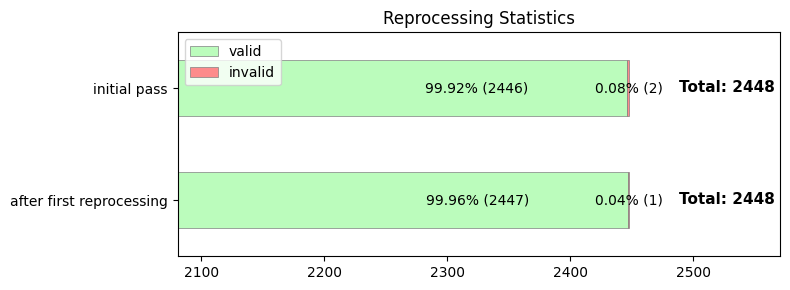

In [28]:
# Plot the reprocessing statistics

# build a dataframe tallying valid and invalid model output
repr_stats_df = pd.DataFrame({
"valid":[result_df.size - repr_stage2_invalid,result_df.size - repr_stage1_invalid],
"invalid":[repr_stage2_invalid,repr_stage1_invalid],
},index =["after first reprocessing","initial pass"]
)

# build and annotate a plot of the dataframe
fig,ax = plt.subplots(1,1,figsize = (8,3))

color_map = {"valid":"#BBFCBC","invalid":"#FD8B8B"}
repr_stats_df.plot(
    kind = "barh",
    stacked = True,
    ax = ax,
    color = [color_map[col] for col in repr_stats_df.columns],
    edgecolor = "gray",
    linewidth = 0.5
)
                   
ax.set_xlim([result_df.size*0.85,result_df.size*1.05])
ax.set_title("Reprocessing Statistics")

# annotate percentages
for container in ax.containers:
    for rect in container:
        width = rect.get_width()
        if width > 0:
            percentage = 100 * width / result_df.size
            ax.annotate(f"{percentage:.2f}% ({width:.0f})",
                        xy=(rect.get_x() + width*0.95,
                            rect.get_y() + rect.get_height() / 2),
                        ha="center", va="center", fontsize=10, color="black")

for idx,row in enumerate(repr_stats_df.itertuples()):
    total = row.valid + row.invalid
    ax.annotate(f"Total: {total}",
                xy=(total,idx),
                xytext=(70, -5),
                textcoords="offset points",
                ha="center", va="bottom", fontsize=11, fontweight="bold")
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title ="", loc="upper left")
plt.tight_layout()